<a href="https://colab.research.google.com/github/ldeloe/IST-Data-Fusion/blob/main/co_registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install netCDF4

In [2]:
!cp /content/drive/MyDrive/Sentinel-1/functions.py .

In [3]:
!cp /content/drive/MyDrive/Sentinel-1/utils.py .

In [4]:
from netCDF4 import Dataset
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import xarray as xr
from datetime import datetime
from osgeo import ogr
from shapely.geometry import Polygon, Point
import xml.etree.ElementTree as ET
import scipy
from os import listdir
from os.path import isfile, join

# --Proprietary modules -- #
from functions import chart_cbar
from utils import CHARTS, GROUP_NAMES, LOOKUP_NAMES, SIC_LOOKUP, SOD_LOOKUP, FLOE_LOOKUP, SCENE_VARIABLES

# Functions

Find the Date-Time Range for VIIRS Files

In [5]:
# create xarray dataset from Sentinel-1 .nc file
def load_Sentinel(file):
  os.environ['AI4ARCTIC_DATA'] = ''
  os.environ['AI4ARCTIC_ENV'] = ''
  Sentinel_data = xr.open_dataset(os.path.join(os.environ['AI4ARCTIC_DATA'], file))
  return Sentinel_data

Find Compatible VIIRS Files

In [6]:
# create a summary .xml file for all files tested in the trial
def write_trials_XML(filename,date_Sentinel,sentinel_filepath,sentinel_filename,
               VIIRS_filepath,VIIRS_filenames) :

  root = ET.Element('TrialData')

  # Create Date element
  date_element = ET.SubElement(root, 'Date')
  date_element.text = date_Sentinel

  # Create SentinelPath element
  sentinel_path_element = ET.SubElement(root, 'SentinelPath')
  sentinel_path_element.text = sentinel_filepath

  # Create SentinelFile element
  sentinel_file_element = ET.SubElement(root, 'SentinelFile')
  sentinel_file_element.text = sentinel_filename

  # Create VIIRSPath element
  viirs_path_element = ET.SubElement(root, 'VIIRSPath')
  viirs_path_element.text = VIIRS_filepath

  # Create VIIRSFile element
  viirs_file_element = ET.SubElement(root, 'VIIRSFiles')

  # Add each VIIRS file as a sub-element of VIIRSFile
  for file in VIIRS_filenames:
      file_element = ET.SubElement(viirs_file_element, 'VIIRSFile')
      file_element.text = file

  # Create the XML tree
  tree = ET.ElementTree(root)

  # Save the XML file
  tree.write(filename)

# write the compatibility information for each compatible file to .xml
def write_compatible_VIIRS_XML(filename, date_Sentinel, sentinel_filepath, sentinel_filename,
                         VIIRS_filepath, VIIRS_filenames, latitudes, longitudes,
                         dates, hours, areas):

  root = ET.Element('CompatibleVIIRSFiles')

  # Create Date element
  date_element = ET.SubElement(root, 'Date')
  date_element.text = date_Sentinel

  # Create SentinelPath element
  sentinel_path_element = ET.SubElement(root, 'SentinelPath')
  sentinel_path_element.text = sentinel_filepath

  # Create SentinelFile element
  sentinel_file_element = ET.SubElement(root, 'SentinelFile')
  sentinel_file_element.text = sentinel_filename

  # Create VIIRSPath element
  viirs_path_element = ET.SubElement(root, 'VIIRSPath')
  viirs_path_element.text = VIIRS_filepath

  # Create VIIRSFile element
  viirs_file_element = ET.SubElement(root, 'VIIRSFiles')

  # Add the compatibility information for each VIIIRSFile
  for idx in range(0,len(VIIRS_filenames)):
    file_element = ET.SubElement(viirs_file_element, 'VIIRSFile')
    file_element.text = VIIRS_filenames[idx]
    date_element = ET.SubElement(viirs_file_element, 'DifferenceDates')
    date_element.text = str(dates[idx])
    time_element = ET.SubElement(viirs_file_element, 'DifferenceAcquisitionTimes')
    time_element.text = str(hours[idx])
    for i in range(0,len(latitudes[idx])-1):
      file_element = ET.SubElement(viirs_file_element, 'LatitudeIntersection')
      file_element.text = str(latitudes[idx][i])
      file_element = ET.SubElement(viirs_file_element, 'LongitudeIntersection')
      file_element.text = str(longitudes[idx][i])
    area_element = ET.SubElement(viirs_file_element, 'DifferenceAreas')
    area_element.text = str(areas[idx])

  # Create the XML tree
  tree = ET.ElementTree(root)

  # Save the XML file
  tree.write(f'{filename}')

# check each .xml file for date, acquisition time, and area
def find_compatible_xmls(filepath_VIIRS, filename, filepath_Sentinel, compatible_files,
                    incompatible_files, common_latitudes, common_longitudes,
                    overlap, hours, dates):
  ### VIIRS Data ###
  tree = ET.parse(filepath_VIIRS+filename)
  root = tree.getroot()

  time_VIIRS = root.find('.//RangeBeginningTime').text.replace('.000000','')
  date_VIIRS = root.find('.//RangeBeginningDate').text

  points = root.findall('.//Point')
  coordinates = []
  for point in points:
      coordinates.append((float(point.find('PointLatitude').text),float(point.find('PointLongitude').text)))

  polygon_VIIRS = Polygon(coordinates)
  ### VIIRS Data ###

  ### Sentinel Data ###
  sentinel = load_Sentinel(filepath_Sentinel) # re-load on the assumption that we're not running the same trial listed above
  file_id = sentinel.attrs['scene_id']
  id = sentinel.attrs['original_id']
  date_Sentinel = id[17:21] + '-' + id[21:23] + '-' + id[23:25]
  time_Sentinel = id[26:28] + ':' + id[28:30] + ':' + id[30:32]

  latitude_sentinel_1 = np.around(sentinel.variables['sar_grid2d_latitude'][:,:], decimals=5)
  longitude_sentinel_1 = np.around(sentinel.variables['sar_grid2d_longitude'][:,:], decimals=5)

  polygon_Sentinel = Polygon([(latitude_sentinel_1[0,0],longitude_sentinel_1[0,0]), (latitude_sentinel_1[-1,0],longitude_sentinel_1[-1,0]), (latitude_sentinel_1[-1,-1],longitude_sentinel_1[-1,-1]),(latitude_sentinel_1[0,-1],longitude_sentinel_1[0,-1])])
  ### Sentinel Data ###

  ### VIIRS File ###
  print(f'VIIRS File Name: {filename}')

  ### Acquisition Times ###
  diff_hours = check_time_difference(time_VIIRS, time_Sentinel)

  ### Dates ###
  diff_days = check_date(date_VIIRS, date_Sentinel)

  ### Grids ###
  coords_of_intersection, percent_overlap, intersects = check_polygons(str(polygon_VIIRS),str(polygon_Sentinel))

  if intersects:
    print(f'Intersection at latitudes: {coords_of_intersection[::2]}, longitudes: {coords_of_intersection[1::2]}')
    print(f'Overlap with Sentinel-1 [%]: {percent_overlap}\n')
  else:
    print('Grids do not intersect\n')

  # save information for files that meet the criteria
  if (diff_hours <= 8) & (diff_days == 0)  & intersects & (percent_overlap >= 70):
    compatible_files.append(filename)
    common_latitudes.append(coords_of_intersection[::2])
    common_longitudes.append(coords_of_intersection[1::2])
    overlap.append(percent_overlap)
    hours.append(diff_hours)
    dates.append(diff_days)
  else:
    incompatible_files.append(filename)

  return compatible_files, incompatible_files, common_latitudes, common_longitudes, overlap, hours, dates

# check acquisition times
def check_time_difference(time_VIIRS, time_Sentinel):
  VIIRS = datetime.strptime(time_VIIRS, "%H:%M:%S")
  Sentinel = datetime.strptime(time_Sentinel, "%H:%M:%S")

  delta = np.absolute(VIIRS - Sentinel)
  hours = np.around(delta.total_seconds() / (60 * 60), decimals = 2)
  print('Difference in acquisition times [hr]: ', hours)

  return hours

# check acquisition dates
def check_date(date_VIIRS, date_Sentinel):
  VIIRS = datetime.strptime(date_VIIRS, "%Y-%m-%d")
  Sentinel = datetime.strptime(date_Sentinel, "%Y-%m-%d")

  delta = np.absolute(VIIRS - Sentinel)
  print(f'Difference in dates [days]: {delta.days}')

  return delta.days

# check area covered by swath/grid
def check_polygons(polygon_VIIRS,polygon_Sentinel):
  poly1 = ogr.CreateGeometryFromWkt(polygon_VIIRS)
  poly2 = ogr.CreateGeometryFromWkt(polygon_Sentinel)

  intersection = poly1.Intersection(poly2)

  if str(intersection) == 'POLYGON EMPTY': #None
    return np.empty(0), 0, False

  # calculate the difference in areas
  area_sentinel = poly2.GetArea()
  area_intersection = intersection.GetArea()
  percent_area = (area_intersection/area_sentinel)*100

  intersection = str(intersection).replace('POLYGON ((', '').replace('))','').replace(' ',',').split(",")
  coords_of_intersection = [float(coord) for coord in intersection]

  return np.array(coords_of_intersection), percent_area, True

# automate the process of checking each .xml file in the trial
def load_trial(trial_filename):
  # Retrieve the file data
  tree = ET.parse(trial_filename)
  root = tree.getroot()

  path_viirs = root.find('.//VIIRSPath').text
  path_sentinel = root.find('.//SentinelPath').text + root.find('.//SentinelFile').text

  viirs_files_element = root.find('.//VIIRSFiles')
  viirs_files = viirs_files_element.findall('.//VIIRSFile')

  compatible_files = []
  incompatible_files = []
  common_latitudes = []
  common_longitudes = []
  overlap = []
  hours = []
  dates = []

  for viirs_file in viirs_files:
    compatible_files, incompatible_files, common_latitudes, common_longitudes, overlap, hours, dates = find_compatible_xmls(path_viirs, viirs_file.text, path_sentinel, compatible_files, incompatible_files, common_latitudes, common_longitudes, overlap, hours, dates)

  print(f'COMPATIBLE FILES: {compatible_files}')
  print(f'Intersecting Latitudes: {common_latitudes}')
  print(f'Intersecting Longitudes: {common_longitudes}')
  print(f'Percent Overlap with Sentinel-1: {overlap}')
  print(f'Difference in hours: {hours}')
  print(f'Difference in dates: {dates}')
  print(f'\nINCOMPATIBLE FILES: {incompatible_files}\n')


  compatible_filename = root.find('.//SentinelPath').text + 'compatible-with-' + root.find('.//Date').text + '.xml'
  write_compatible_VIIRS_XML(compatible_filename,root.find('.//Date').text,path_sentinel,root.find('.//SentinelFile').text,
                       path_viirs,compatible_files,common_latitudes,common_longitudes,dates,hours,overlap)

  return path_viirs, path_sentinel, compatible_files, common_latitudes, common_longitudes, overlap, root.find('.//Date').text, compatible_filename

Plot the subset of VIIRS data that overlaps with Sentinel-1

In [20]:
# set any coordinates outside of the overlapping area to nan
def set_coordinates_outside_polygon(lon_array, lat_array, polygon):
  lat = lat_array +180 # the code gets angry at the -180 - 180 point
  lon = lon_array +180

  mask = np.zeros(len(lon_array), dtype=bool)

  for i in range(0,len(lon_array)):
    mask[i] = not polygon.contains(Point(lat[i],lon[i]))

  np.put(lat_array, np.where(mask==True), np.nan)
  np.put(lon_array, np.where(mask==True), np.nan)

  return lon_array, lat_array

# crop the array such that the outermost rows/columns have real values
def crop_array(lat, lon, data=None):
    # Find rows and columns with at least one non-NaN value
    non_nan_rows = np.any(~np.isnan(lon), axis=1)
    non_nan_cols = np.any(~np.isnan(lon), axis=0)

    # Crop the array based on rows and columns with at least one non-NaN value
    cropped_lat = lat[non_nan_rows][:, non_nan_cols]
    cropped_lon = lon[non_nan_rows][:, non_nan_cols]
    if data.all() != None:
      cropped_data = data[non_nan_rows][:, non_nan_cols]
      return cropped_data, cropped_lat, cropped_lon

    return cropped_lat, cropped_lon

# interpolate IST such that each value is contained in the colour bar
def temperature_categories(data):
  temp_range = np.linspace(234,273,40)
  discrete_temps = [234,235,237,239,240,242,244,245,247,249,250,252,254,255,257,259,260,262,264,265,267,269,271,273]

  for i in range(0,len(temp_range)):
    if temp_range[i] not in discrete_temps:
      closest_temp = (np.absolute(discrete_temps - temp_range[i])).argmin()

      indices = np.where(data == temp_range[i])
      np.put(data, indices, discrete_temps[closest_temp])

  return data

# plot VIIRS IST
def plot_imshow(data, bins, max_lat, max_lon, min_lat, min_lon, filename, date):
  colours = [(1.00, 1.00, 1.00), (0.72, 0.72, 0.72), (1.00, 1.00, 0.59),
             (0.1843, 0.4941, 0.1843), (0.14, 0.14, 0.56), (0.14, 0.14, 0.76),
             (0.4549, 0.4549, 0.4549), (0.3255, 0.9059, 0.9686), (0.7882, 0.9137, 0.9725),
             (0.5647, 0.7882, 0.8549), (0.5333, 0.7686, 0.8706), (0.4039, 0.7216, 0.8353),
             (0.2706, 0.5804, 0.8431), (0.2392, 0.4392, 0.6980), (0.1843, 0.3176, 0.5686),
             (0.7765, 0.7137, 0.8157),
             (0.7765, 0.6863, 0.8000), (0.6824, 0.5725, 0.7333), (0.6745, 0.5569, 0.7059),
             (0.6275, 0.4863, 0.6745), (0.5922, 0.4627, 0.6471), (0.4980, 0.3412, 0.5765),
             (0.4784, 0.3176, 0.5529), (0.3843, 0.1255, 0.4784), (0.8549, 0.6902, 0.7059),
             (0.8627, 0.5843, 0.6000), (0.8196, 0.4824, 0.4863), (0.7804, 0.3569, 0.3451),
             (0.7137, 0.3255, 0.3059), (0.6431, 0.2941, 0.3020), (0.4941, 0.2824, 0.2824),
             (0.4392, 0.2510, 0.2510), (1.00, 0.0784, 0.5765), (0.00, 0.00, 0.00)]

  labels = ['missing data', 'no dec/inval/avg cont flg', 'night', 'land', 'inland water', 'ocean', 'cloud', '210-213 K',
          '213-234 K','235 K','237 K','239 K','240 K','242 K','244 K','245 K',
          '247 K','249 K','250 K','252 K','254 K','255 K','257 K','259 K',
          '260 K','262 K','264 K','265 K','267 K','269 K','271 K','273-275 K', '257-310 K melt', 'fill value']

  cmap = mpl.colors.ListedColormap(colours)
  norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))
  fig, ax = plt.subplots(figsize=(10,10))

  secx = ax.secondary_xaxis('top')
  secy = ax.secondary_yaxis('right')

  secx.set(xticklabels=np.round(np.linspace(min_lat[0],min_lat[-1],num=7)))
  secy.set(yticklabels=np.round(np.linspace(min_lon[0],min_lon[-1],num=7)))

  print(f'Plotting: {filename}')
  plt.imshow(data, cmap=cmap, norm=norm, interpolation='nearest', alpha=0.9, extent = [max_lat[-1],max_lat[0],max_lon[0],max_lon[-1]],aspect='auto')  # Display RGB as an image
  cbar = plt.colorbar(pad=0.1)
  cbar.ax.set_yticks(bins)
  cbar.ax.set_yticklabels(labels)
  plt.title(filename + ', ' + date)
  plt.show()

# find the lat-lon bounds of the cropped image, for use with imshow
def find_first_last_real_values(arr):
    # Find indices of non-NaN values
    non_nan_indices = np.where(~np.isnan(arr))[0]

    # Check if there are any real values in the array
    if len(non_nan_indices) == 0:
        return None, None

    # Find the first and last real values
    first_real_value = arr[non_nan_indices[0]]
    last_real_value = arr[non_nan_indices[-1]]

    return (first_real_value, last_real_value)

# discretize the IST values, for use with imshow
def discretize_IST(IST, latitude, longitude, dims, title, date, crop):
  z = [0,100,1100,2500,3700,3900,5000,210, 234,235,237,239,240,242,244,245,247,249,250,252,254,255,257,259,260,262,264,265,267,269,271,273,310,65533]

  data = np.round(IST)
  data_raw = data
  num_levels = len(z)
  bins = np.linspace(0,num_levels-1,len(z))
  data = temperature_categories(data)

  for i in range(0,len(bins)):
    if z[i] == 234:
      outliers = (data_raw <= 234) & (data_raw >= 213)
      indices = np.where(outliers == True)
      np.put(data, indices, bins[i])

      low_temp = (data_raw < 213) & (data_raw >= 210)
      invalid_temp = (data_raw < 210) & (data_raw > 100)

    elif z[i] == 210:
        outliers = (data_raw < 213) & (data_raw >= 210)
        indices = np.where(outliers == True)
        np.put(data, indices, bins[i])

        invalid_temp = (data_raw < 210) & (data_raw > 100)
        if invalid_temp.any():
          indices = np.where(invalid_temp == True)
          np.put(data, indices, bins[1])

    elif z[i] == 273:
      outliers = (data_raw >= 273) & (data_raw <= 275)
      indices = np.where(outliers == True)
      np.put(data, indices, bins[i])

    elif z[i] == 310:
        outliers = (data_raw > 275) & (data_raw <= 310)
        indices = np.where(outliers == True)
        np.put(data, indices, bins[i])

        invalid_temp = (data_raw > 310) & (data_raw < 655)
        if invalid_temp.any():
          indices = np.where(invalid_temp == True)
          np.put(data, indices, bins[1])
    else:
      indices = np.where(data_raw == z[i])
      np.put(data,indices,bins[i])

  outliers = (np.isnan(latitude)) & (np.isnan(longitude))
  indices = np.where(outliers == True)
  np.put(data, indices, np.nan)

  lat = latitude.reshape(dims)
  lon = longitude.reshape(dims)

  if crop:
    data, lat, lon = crop_array(lat, lon, data.reshape(dims))
  else:
    data = data.reshape(dims)

  max_lat = find_first_last_real_values(lat[:,0])
  min_lat = find_first_last_real_values(lat[:,-1])
  max_lon = find_first_last_real_values(lon[0,:])
  min_lon = find_first_last_real_values(lon[-1,:])

  print(f'Verify discrete IST values: {np.unique(data)}')
  plot_imshow(data, bins, max_lat, max_lon, min_lat, min_lon, title, date) #dims)

Create the VIIRS .nc File for Co-Registering with Sentinel-1

In [8]:
# create xarray dataset and write VIIRS lat, lon, and IST data to netcdf4
def create_nc_VIIRS(IST, latitude, longitude, dims, filepath, filename):
  flags = [0,100,1100,2500,3700,3900,5000,65533]
  bins = [0,1,2,3,4,5,6,33]
  data = IST
  data_raw = data

  for i in range(0,len(bins)):
    indices = np.where(data_raw == flags[i])
    np.put(data,indices,bins[i])

  outliers = (np.isnan(latitude)) & (np.isnan(longitude))
  indices = np.where(outliers == True)
  np.put(data, indices, np.nan)

  data, latitude, longitude = crop_array(latitude.reshape(dims), longitude.reshape(dims), data.reshape(dims))

  print(f'Verify IST values: {np.unique(np.round(data))}')

  VIIRS_nc = xr.Dataset(
    data_vars=dict(
        IST=(["x","y"], data),
        lon=(["x","y"], longitude),
        lat=(["x","y"], latitude),
    ),
    attrs=dict(description="VIIRS ice surface temperature, latitude, and longitude data."),
  )

  VIIRS_nc.to_netcdf(path= filepath + filename)

  return VIIRS_nc

# crop to overlapping range and plot VIIRS, write to .nc
def format_VIIRS(path_viirs, path_sentinel, compatible_files, common_latitudes, common_longitudes, plot):
  for idx in range(0,1): #len(compatible_files)):
    filename = compatible_files[idx].replace('.xml','')
    rootgrp = Dataset(path_viirs + filename)

    IST = np.array(rootgrp.groups['IST_Data'].variables['IST_map'])
    latitude = np.array(rootgrp.groups['Geolocation_Data'].variables['latitude'])
    longitude = np.array(rootgrp.groups['Geolocation_Data'].variables['longitude'])

    dims = IST.shape

    coordinates = []
    for i in range(0,len(common_latitudes[idx])):
      coordinates.append((common_latitudes[idx][i]+180,common_longitudes[idx][i]+180))

    common_polygon = Polygon(coordinates)

    filtered_lon, filtered_lat = set_coordinates_outside_polygon(longitude.flatten(), latitude.flatten(), common_polygon)

    if plot:
      crop = True
      discretize_IST(IST.flatten(),filtered_lat,filtered_lon, dims, filename, date, crop)

    VIIRS_nc = create_nc_VIIRS(IST.flatten(), filtered_lat, filtered_lon, dims, path_viirs, 'CROPPED_'+filename)

    return VIIRS_nc

Interpolate Sentinel-1, Create the .nc File for Co-Registering with VIIRS




In [9]:
# interpolate the Sentinel-1 lat-lon grid to be the same dimensions as the SAR data
def interpolate_lat_lon(source, dim_x, dim_y):
  # interpolate values within a column (increase # of rows)
  x = np.arange(0, np.array(source).shape[0])
  fit = scipy.interpolate.interp1d(x, source, axis=0)
  target = fit(np.linspace(0, np.array(source).shape[0]-1, dim_x))

  #interpolate values within a row (increase # of columns)
  x = np.arange(0, np.array(source).shape[1])
  fit = scipy.interpolate.interp1d(x, target, axis=1)
  target = fit(np.linspace(0, np.array(source).shape[1]-1, dim_y))

  return target

# write interpolated Sentinel-1 data to netcdf4
def format_Sentinel(sentinel_data, path_sentinel, viirs_file, compatible_files,
                    common_latitudes, common_longitudes, percent_overlap):

  latitude_sentinel_1 = sentinel_data.variables['sar_grid2d_latitude'][:,:]
  longitude_sentinel_1 = sentinel_data.variables['sar_grid2d_longitude'][:,:]
  dim_x = sentinel_data.dims['sar_lines']
  dim_y = sentinel_data.dims['sar_samples']

  latitude_sentinel_1 = interpolate_lat_lon(latitude_sentinel_1, dim_x, dim_y)
  longitude_sentinel_1 = interpolate_lat_lon(longitude_sentinel_1, dim_x, dim_y)

  latitude_sentinel_1 = np.around(latitude_sentinel_1, decimals=5)
  longitude_sentinel_1 = np.around(longitude_sentinel_1, decimals=5)

  files = [string.replace('.xml', '') for string in compatible_files]

  idx = np.where(np.char.find(files, viirs_file) != -1)[0]
  if percent_overlap[idx] < 100:
    print(f'Overlap [%]: {percent_overlap}')
    coordinates = []
    for i in range(0,len(common_latitudes[idx])):
      coordinates.append((common_latitudes[idx][i]+180,common_longitudes[idx][i]+180))

    common_polygon = Polygon(coordinates)

    lon, lat = set_coordinates_outside_polygon(longitude_sentinel_1.flatten(), latitude_sentinel_1.flatten(), common_polygon)

    plt.scatter(latitude_sentinel_1, longitude_sentinel_1)

    latitude_sentinel_1, longitude_sentinel_1 = crop_array(lat.reshape(dim_x,dim_y), lon.reshape(dim_x,dim_y))

    plt.scatter(latitude_sentinel_1, longitude_sentinel_1)
    plt.show()

    dim_x, dim_y = longitude_sentinel_1.shape

  Sentinel_nc = xr.Dataset(
    data_vars=dict(
        lon=(["x","y"], longitude_sentinel_1),
        lat=(["x","y"], latitude_sentinel_1),
    ),
    attrs=dict(description="Sentinel-1 latitude and longitude data."),
  )
  Sentinel_nc.to_netcdf(path= path_sentinel + 'CROPPED_' + sentinel_data.attrs['scene_id'].replace('.nc',''))
  dim_x, dim_y = longitude_sentinel_1.shape

  return Sentinel_nc, dim_x, dim_y

# add the file name and cropped dimensions of the selected VIIRS file to the compatible-with .xml file
def add_dims_xml(trial_filename_xml, viirs_file, dim_x, dim_y):
  # Load the existing XML file
  tree = ET.parse(trial_filename_xml)
  root = tree.getroot()

  # Find the VIIRSFiles element
  viirs_files_element = root.find('.//CompatibleVIIRSFiles')

  selected_viirs_element = ET.SubElement(root, 'SelectedVIIRSFile')
  selected_viirs_element.text = str(viirs_file)

  # Create new sub-elements
  dim_x_element = ET.SubElement(root, 'DimXCropped')
  dim_x_element.text = str(dim_x)

  dim_y_element = ET.SubElement(root, 'DimYCropped')
  dim_y_element.text = str(dim_y)

  # Save the modified XML file
  tree.write(trial_filename_xml)

# variation of the plotting script provided by AI4Arctic
def sentinel_plots(scene):

  file_id = scene.attrs['scene_id']
  id = scene.attrs['original_id']
  date = id[17:21] + '-' + id[21:23] + '-' + id[23:25]
  time = id[26:28] + ':' + id[28:30] + ':' + id[30:32]

  # Show full resolution variables.
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
  fig.suptitle(file_id + ', ' + date + ', ' + time, size=20)
  for idx, full_variable in enumerate(SCENE_VARIABLES[0:4]):
      ax = axs[idx // 2, idx % 2]
      if 'nersc_sar' in full_variable:
          scene[full_variable].values[scene[full_variable].values == scene[full_variable].attrs['variable_fill_value']] = np.nan
          label = 'Scaled backscatter'
          im = ax.imshow(scene[full_variable].values, cmap='gray',
                        vmin=np.nanquantile(scene[full_variable].values, q=0.025),
                        vmax=np.nanquantile(scene[full_variable].values, q=0.975))
      elif 'incidenceangle' in full_variable:
          scene[full_variable].values[scene[full_variable].values == scene[full_variable].attrs['variable_fill_value']] = np.nan
          label = 'Incidence angle'
          im = ax.imshow(scene[full_variable].values)
      elif 'map' in full_variable:
          label = 'Distance to land'
          im = ax.imshow(scene[full_variable].values)
      plt.colorbar(im, ax=ax, fraction=0.0485, pad=0.049, label=label)

  fig.tight_layout()

# Plot Re-sampled Data

In [10]:
# read the co-registered VIIRS csv
def read_resampled_VIIRS(filename, compatible_file, trial_date, dims):
  data = pd.read_csv(filename)

  latitude = data['lat'].to_numpy()
  longitude = data['lon'].to_numpy()
  IST = data['ist'].to_numpy()

  crop = False
  discretize_IST(IST.flatten(),latitude.flatten(),longitude.flatten(), dims, compatible_file, trial_date, crop)

def get_trial_data(filepath):
  tree = ET.parse(filepath)
  root = tree.getroot()

  compatible_file = 'Co-registered ' + root.find('.//SelectedVIIRSFile').text
  trial_date = root.find('.//Date').text
  dim_x = root.find('.//DimXCropped').text
  dim_y = root.find('.//DimYCropped').text

  return compatible_file, trial_date, dim_x, dim_y

# Function Calls

**INSTRUCTIONS FOR RE-RUNNNING A PREVIOUS TRIAL:**

*   Delete the corresponding CROPPED_ nc files
*   Delete the compatible-with xml file



**Load Sentinel-1 Data**

In [11]:
sentinel_filename = '20190406T102029_cis_prep.nc'
sentinel_filepath = '/content/drive/MyDrive/Sentinel-1/'
VIIRS_filepath = '/content/drive/MyDrive/VIIRS/'

### Load the Sentinel-1 trial file ###
Sentinel_data = load_Sentinel(sentinel_filepath + sentinel_filename)
### Load the Sentinel-1 trial file ###

file_id = Sentinel_data.attrs['scene_id']
id = Sentinel_data.attrs['original_id']

# find the date and time of acquisition
date_Sentinel = id[17:21] + '-' + id[21:23] + '-' + id[23:25]
time_Sentinel = id[26:28] + ':' + id[28:30] + ':' + id[30:32]

# find the latitude/longitude bounds
latitude_sentinel_1 = np.around(np.array(Sentinel_data.variables['sar_grid2d_latitude'][:,:]), decimals=5)
longitude_sentinel_1 = np.around(np.array(Sentinel_data.variables['sar_grid2d_longitude'][:,:]), decimals=5)
lat_bounds = (latitude_sentinel_1[0,0],latitude_sentinel_1[-1,0],latitude_sentinel_1[0,-1],latitude_sentinel_1[-1,-1])
lon_bounds = (longitude_sentinel_1[0,0],longitude_sentinel_1[-1,0],longitude_sentinel_1[0,-1],longitude_sentinel_1[-1,-1])

print("FIND VIIRS FILES WITH THE FOLLOWING INFORMATION")
print(f'Date: {date_Sentinel}')
print(f'Latitudes: {lat_bounds}')
print(f'Longitudes: {lon_bounds}')
print(f'Latitude-Longitude Bounds: {min(lon_bounds)}, {min(lat_bounds)}, {max(lon_bounds)}, {max(lat_bounds)}')

FIND VIIRS FILES WITH THE FOLLOWING INFORMATION
Date: 2019-04-06
Latitudes: (56.27944, 54.52394, 57.00213, 55.23467)
Longitudes: (-56.23009, -56.99729, -62.94359, -63.42001)
Latitude-Longitude Bounds: -63.42001, 54.52394, -56.23009, 57.00213


Generate Trial Information .xml File

**ONLY PROCEED ONCE THE .XML FILES ARE UPLOADED TO THE DRIVE**

In [12]:
# find all VIIRS xml files
VIIRS_filenames = [f for f in listdir(VIIRS_filepath) if f.endswith(".xml") & isfile(join(VIIRS_filepath, f))]

### Write the trial information to an xml file ###
trial_filename = sentinel_filepath + date_Sentinel + '.xml'
write_trials_XML(trial_filename,date_Sentinel,sentinel_filepath,sentinel_filename,VIIRS_filepath,VIIRS_filenames)
### Write the trial information to an xml file ###

print(f'WRITE THE TRIAL INFORMATION TO {trial_filename}')

WRITE THE TRIAL INFORMATION TO /content/drive/MyDrive/Sentinel-1/2019-04-06.xml


**Find and Store Compatible VIIRS Files**

In [13]:
print("CHECK EACH VIIRS .XML FILE FOR COMPATIBILITY\n")
### Load the trial ###
path_viirs, path_sentinel, compatible_files, common_latitudes, common_longitudes, percent_overlap, date, trial_filename_xml = load_trial(trial_filename)
### Load the trial ###

CHECK EACH VIIRS .XML FILE FOR COMPATIBILITY

VIIRS File Name: VNP30.A2019096.0642.001.2019096122202.nc.xml
Difference in acquisition times [hr]:  3.64
Difference in dates [days]: 0
Intersection at latitudes: [57.00213 55.23467 54.52394 56.27944 57.00213], longitudes: [-62.94359 -63.42001 -56.99729 -56.23009 -62.94359]
Overlap with Sentinel-1 [%]: 100.0

VIIRS File Name: VNP30.A2019096.0500.001.2019096121616.nc.xml
Difference in acquisition times [hr]:  5.34
Difference in dates [days]: 0
Intersection at latitudes: [57.00213 55.23467 54.52394 56.27944 57.00213], longitudes: [-62.94359 -63.42001 -56.99729 -56.23009 -62.94359]
Overlap with Sentinel-1 [%]: 100.0

VIIRS File Name: VNP30.A2019096.0824.001.2019096160956.nc.xml
Difference in acquisition times [hr]:  1.94
Difference in dates [days]: 0
Intersection at latitudes: [56.70783765 57.00213    55.23467    55.11644856 56.70783765], longitudes: [-60.20973222 -62.94359    -63.42001    -62.35166732 -60.20973222]
Overlap with Sentinel-1 [%]

**VIIRS: plot, crop, and store the compatible segment**

PLOT EACH COMPATIBLE VIIRS FILE

Verify discrete IST values: [ 3.  4.  6. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.
 33. nan]
Plotting: VNP30.A2019096.0642.001.2019096122202.nc


<ipython-input-7-582a6e01cd92>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  secx.set(xticklabels=np.round(np.linspace(min_lat[0],min_lat[-1],num=7)))
<ipython-input-7-582a6e01cd92>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  secy.set(yticklabels=np.round(np.linspace(min_lon[0],min_lon[-1],num=7)))


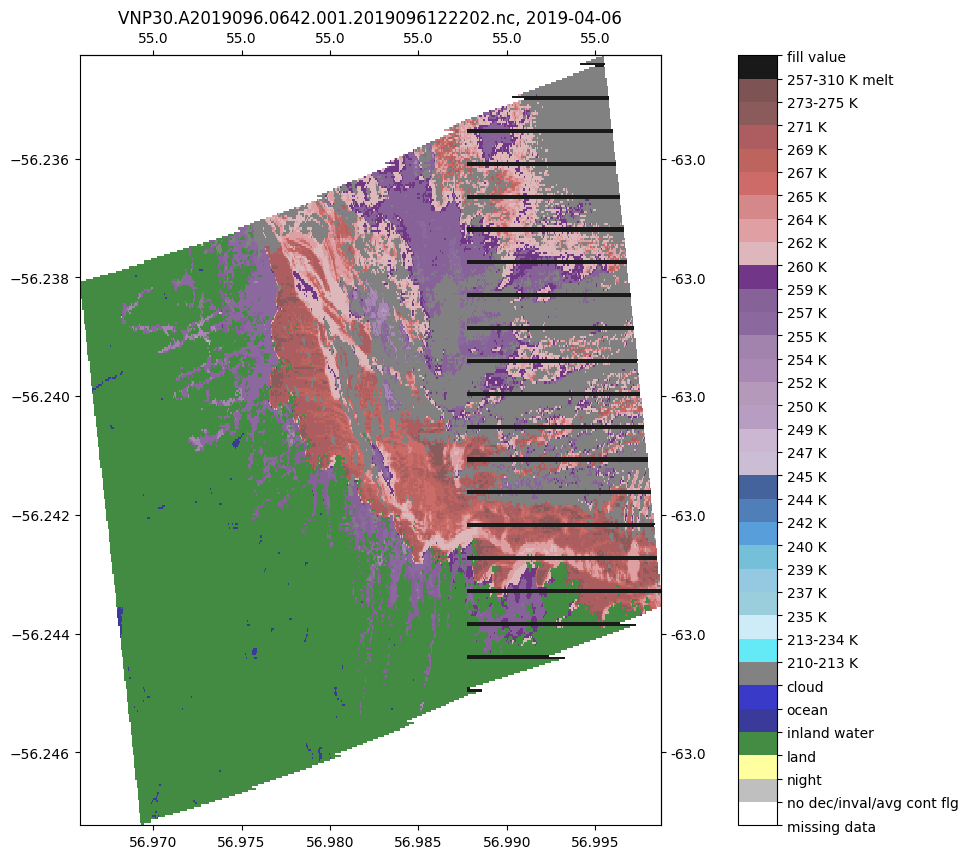

Verify IST values: [  3.   4.   6.  33. 247. 248. 249. 250. 251. 252. 253. 254. 255. 256.
 257. 258. 259. 260. 261. 262. 263. 264. 265. 266. 267. 268. 269. 270.
 271.  nan]


In [14]:
print("PLOT EACH COMPATIBLE VIIRS FILE\n")
plot_segment = True
VIIRS_nc = format_VIIRS(path_viirs, path_sentinel, compatible_files, common_latitudes, common_longitudes, plot_segment)

In [15]:
VIIRS_nc

<xarray.Dataset>
Dimensions:  (x: 375, y: 484)
Dimensions without coordinates: x, y
Data variables:
    IST      (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lon      (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lat      (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    description:  VIIRS ice surface temperature, latitude, and longitude data.

**Sentinel-1: plot data, resample and store the compatible segment**

Plotting: 20190406T102029_cis_prep.nc


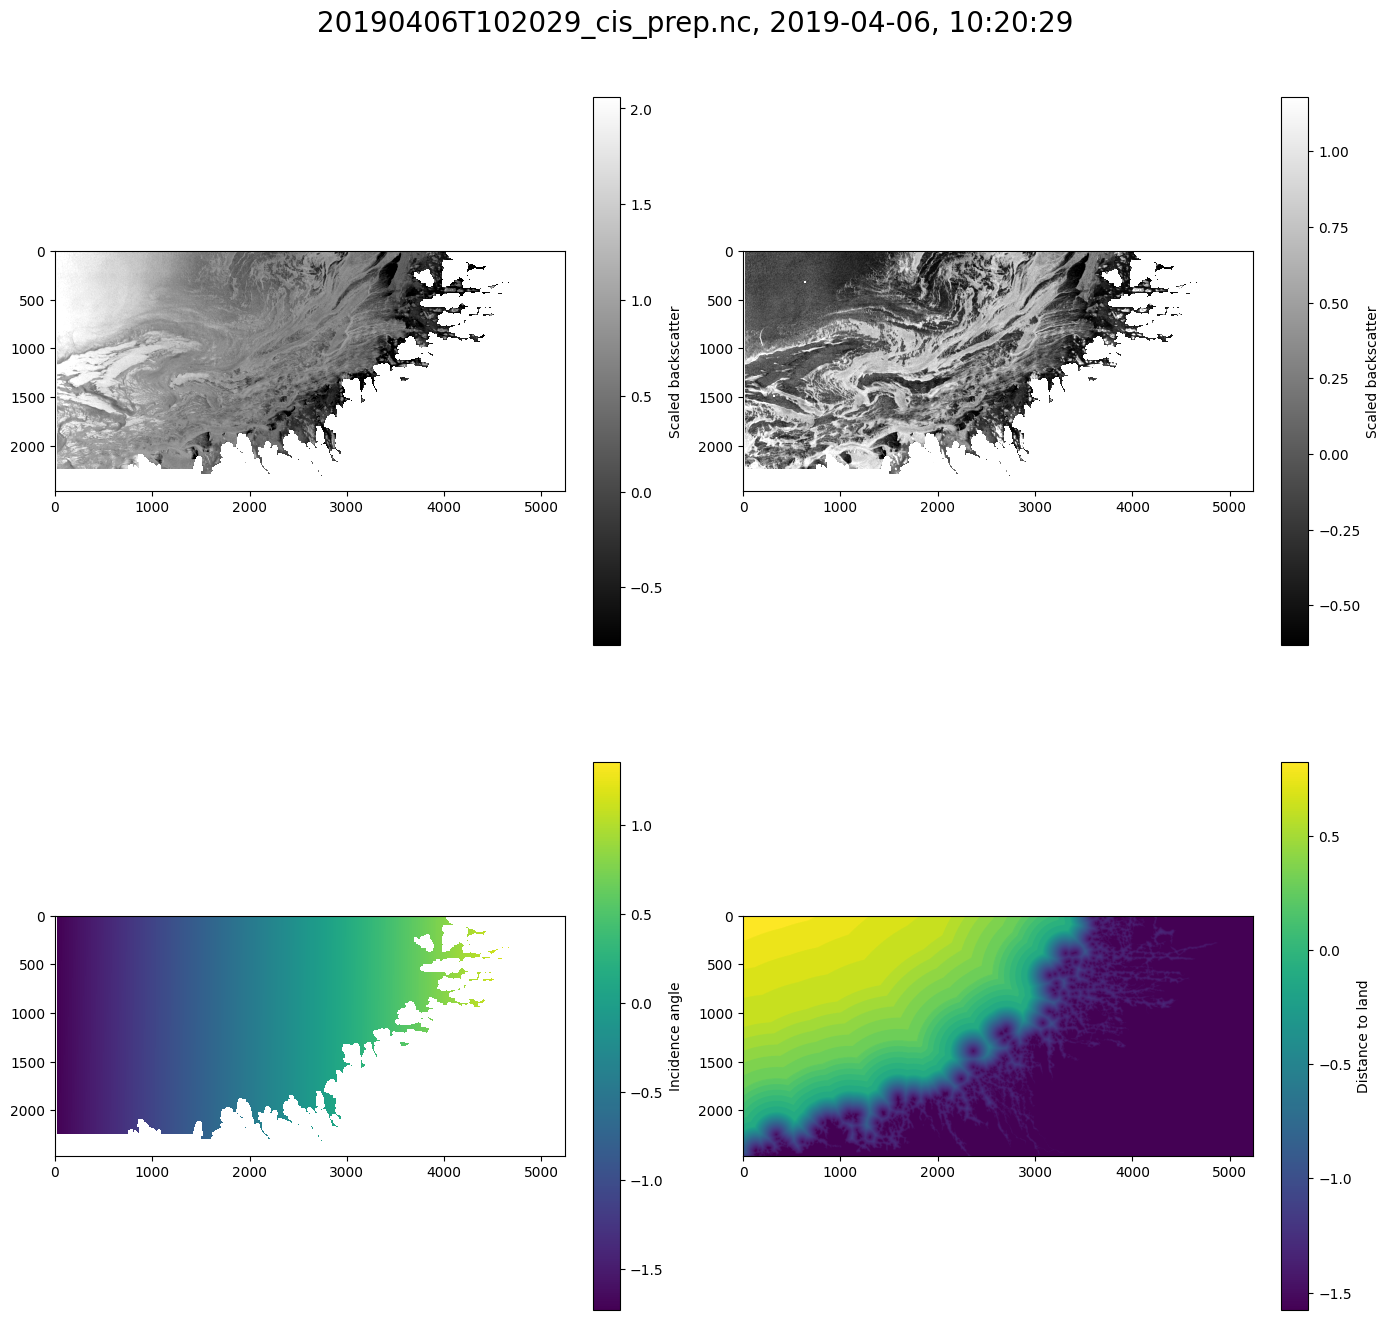

In [16]:
### Load the Sentinel-1 trial file ###
Sentinel_data = load_Sentinel(sentinel_filepath + sentinel_filename)
### Load the Sentinel-1 trial file ###

###
print(f'Plotting: {sentinel_filename}')
sentinel_plots(Sentinel_data)
###

viirs_file = 'VNP30.A2019096.0642.001.2019096122202.nc'
Sentinel_nc, dim_x, dim_y = format_Sentinel(Sentinel_data, sentinel_filepath, viirs_file, np.array(compatible_files), common_latitudes, common_longitudes, np.array(percent_overlap))
add_dims_xml(trial_filename_xml, viirs_file, dim_x, dim_y)

In [17]:
Sentinel_nc

<xarray.Dataset>
Dimensions:  (x: 2468, y: 5244)
Dimensions without coordinates: x, y
Data variables:
    lon      (x, y) float64 -56.23 -56.23 -56.23 -56.23 ... -63.42 -63.42 -63.42
    lat      (x, y) float64 56.28 56.28 56.28 56.28 ... 55.23 55.23 55.23 55.23
Attributes:
    description:  Sentinel-1 latitude and longitude data.

**IF TRIAL WILL NOT BE RE-RUN:**

*   Move all corresponding files to a new folder 'YYYY-MM-DD'

**Load and Plot the Co-Registered Data**

Plotting: 2018_06_23_VNP30A201817408060012018176171327.csv
Verify discrete IST values: [ 1.  3.  6. 25. 26. 27. 28. 29. 30. 31. 32. 33.]
Plotting: Co-registered VNP30.A2018174.0806.001.2018176171327.nc


<ipython-input-20-35a97c3ec23d>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  secx.set(xticklabels=np.round(np.linspace(min_lat[0],min_lat[-1],num=7)))
<ipython-input-20-35a97c3ec23d>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  secy.set(yticklabels=np.round(np.linspace(min_lon[0],min_lon[-1],num=7)))


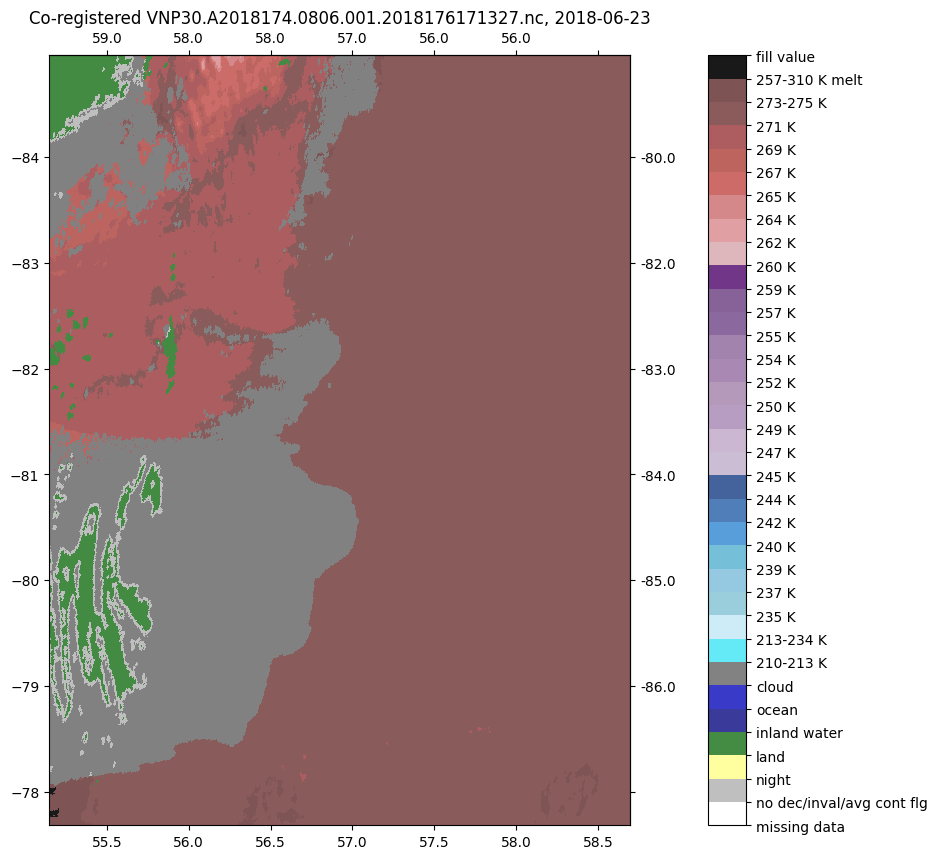

In [23]:
trial_xml = '/content/drive/MyDrive/Sentinel-1/compatible-with-2019-04-06.xml'
compatible_file, trial_date, dim_x, dim_y = get_trial_data(trial_xml)

#2018-06-23
resampled_file = '2018_06_23_VNP30A201817408060012018176171327.csv'
### ONLY SPECIFY DIM_X, DIM_Y IN THIS FORMAT IF RUNNING A FILE FROM BEFORE WRITING TO .XML ###
dim_x = 4996
dim_y = 5319
compatible_file = 'Co-registered VNP30.A2018174.0806.001.2018176171327.nc'
trial_date = '2018-06-23'
### ONLY SPECIFY DIM_X, DIM_Y IN THIS FORMAT IF RUNNING A FILE FROM BEFORE WRITING TO .XML ###

#2018-01-24
#resampled_file = 'newOption.csv'
#dim_x = 5003
#dim_y = 5229

print(f'Plotting: {resampled_file}')
read_resampled_VIIRS(VIIRS_filepath + resampled_file, compatible_file, trial_date, (dim_x,dim_y))